## Steps in creating this trading strategy

#### <span style="color:green">1. Import the necessary libraries </span>
##### <span style="color:green">2. Import the data</span>
#####  <span style="color:green">3. Calculate Parabolic SAR</span>
##### <span style="color:green">4. Calculate Stochastic Oscillator</span>
##### <span style="color:green">5. Trading Signal</span>
##### <span style="color:green">6. Strategy Returns </span>



In [2]:
# #uncomment if you are running from colab
# #talib
# !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
# !tar -xzvf ta-lib-0.4.0-src.tar.gz
# %cd ta-lib
# !./configure --prefix=/usr
# !make
# !make install
# !pip install Ta-Lib
# #download files from repo
# !git clone https://github.com/Datatouille/findalpha.git
# !mv findalpha/data .; ls

## เรียก Library ที่เราจะใช้

In [3]:
# Import Libraires
%matplotlib inline
import pandas as pd # สำหรับจัดการข้อมูลในรูปแบบที่เป็น Srtucture data
import numpy as np # สำหรับจัดการข้อมูลให้อยู่ในรูปแบบหลายมิติ เพื่อใช้กับสูตรคำนวณทางคณิตศาสตร์ที่ซับซ้อน
import talib as ta # สำหรับเรียกใช้ Indicators

from tabulate import tabulate # สำหรับแสดงผลข้อมูลแบบเป็นตาราง

import matplotlib.pyplot as plt # สำหรับแสดงผลข้อมูลเป็นภาพหรือกราฟที่ต้องการ
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')

## Import Data

In [4]:
# อ่านข้อมูล
df = pd.read_csv('data/AUDUSD.csv', index_col='datetime', parse_dates=True)

In [5]:
df.tail(5)

,open,high,low,close,volume
datetime,,,,,
2017-12-22,0.77002,0.77207,0.76996,0.77152,0
2017-12-26,0.77095,0.77299,0.77095,0.77285,0
2017-12-27,0.77274,0.77792,0.77236,0.77701,0
2017-12-28,0.77671,0.78095,0.77644,0.77976,0
2017-12-29,0.77918,0.78249,0.77882,0.78037,0


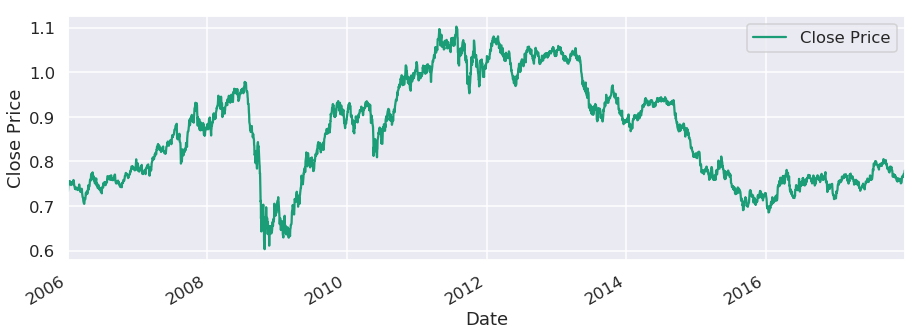

In [6]:
# ทดลองนำราคาปิดของสินทรัพย์มา Plot เป็นกราฟ

df['close'].plot(figsize=(15, 5), label = "Close Price")

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.legend()
plt.show()

## ส่วนของการคำนวณ Indicator จาก Library TA-Lib


เราจะทำการคำนวณค่า slow และ fast stochastic oscillator โดยมีสูตรดังนี้

#### Fast Stochastic Oscillator
```
Fast %K = (Current Close - Lowest Low) / (Highest High - Lowest Low) *100
Fast %D = 3-day Simple Moving Average (SMA) of %K
```
#### Slow Stochastic oscillator
```
Slow %K = Fast %K smoothed with 3-period SMA
Slow %D = 3-period SMA of Slow %K
```

ซึ่งในที่นี้เราจะใช้ 'slowk', 'slowd', 'fastk', 'fastd' functions จาก Library TA-lib โดยมี input คือ high, low และ close prices
ส่วน input parameter คือ 
fastk period = 5, slowk period = 3, fastd_period = 3 และ slowd period =3

In [7]:
# Calculate Stochastic Oscillator
df['fastk'], df['fastd'] = ta.STOCHF(df.high.values, df.low.values, df.close.values ,fastk_period=50, fastd_period=30)
df['slowk'], df['slowd'] = ta.STOCH(df.high.values, df.low.values, df.close.values ,fastk_period=50, slowk_period=30, slowd_period=30)

ต่อมาเป็นการคำนวณค่า indicator SAR โดย Library TA-lib

In [8]:
# Calculate Parabolic SAR
df['SAR'] = ta.SAR(df.high.values, df.low.values, acceleration = 0.02, maximum = 0.2)

ลองนำ Indicator SAR, stochastic oscillator มา Plot เป็น กราฟ

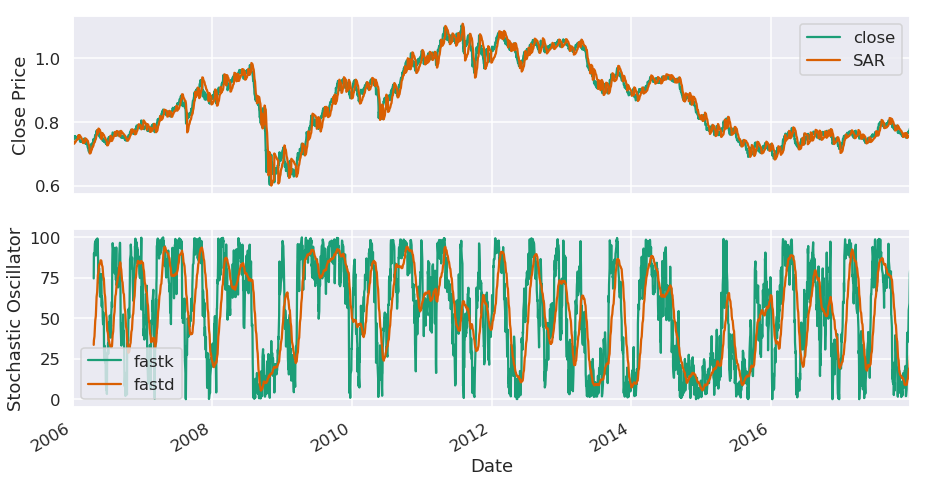

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(15, 8))

df[['close', 'SAR']].plot(label = "Close Price", ax=axes[0])
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Close Price')
axes[0].grid(True)

df[['fastk', 'fastd']].plot(label = "Close Price", ax=axes[1])
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Stochastic Oscillator')
axes[1].grid(True)

plt.legend()
plt.show()

## Trading Signal 

เราจะทำการสร้างสัญญาณการ Buy และ Sell โดยมีเงื่อนไขดังนี้

- Long Signal -- เมื่อเส้น parabolic SAR อยู่ต่ำกว่าราคาปิดและเส้น fast stochastic ตัดเส้น slow stochastic ขึ้น
- Short Signal --  เมื่อเส้น parabolic SAR อยู่สูงกว่าราคาปิดและเส้น fast stochastic ตัดเส้น slow stochastic ลง

In [10]:
# สร้าง Columns ที่ชื่อ Signal ขึ้นมา มีค่าเป็น Null (ค่าว่าง)
df['Signal'] = np.nan

# ทำการกำหนดเงื่อนไข Long Signal (ให้ค่า Signal เป็น 1)
df.loc[(df.SAR < df.close) & (df.fastd > df.slowd) & (df.fastk > df.slowk),'Signal'] =1
# ทำการกำหนดเงื่อนไข Short Signal (ให้ค่า Signal เป็น -1)
df.loc[(df.SAR > df.close) & (df.fastd < df.slowd) & (df.fastk < df.slowk),'Signal'] =-1

# ในช่วงที่ไม่มีสัญญาณ ให้ถือ Position ตามทิศทางของ Signal ที่เกิดขึ้นล่าสุด
df = df.fillna(method='ffill')

datetime
2017-12-15   -1.0
2017-12-18    1.0
2017-12-19    1.0
2017-12-20    1.0
2017-12-21    1.0
2017-12-22    1.0
2017-12-26    1.0
2017-12-27    1.0
2017-12-28    1.0
2017-12-29    1.0
Name: Signal, dtype: float64

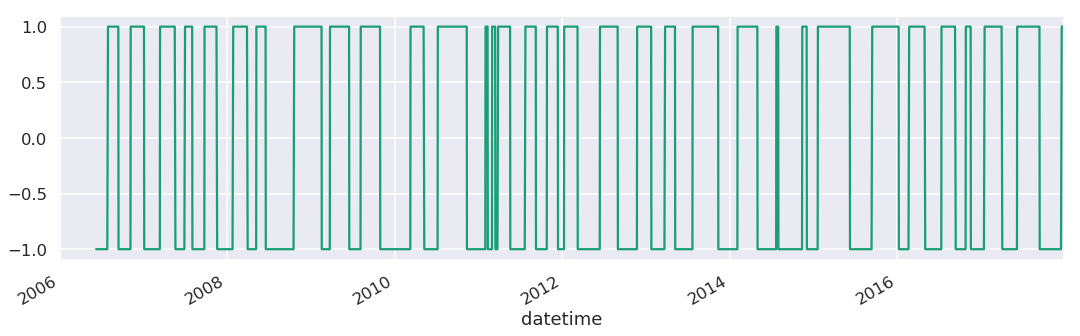

In [11]:
# ทดลองแสดงผลค่าของ Signal

df['Signal'].plot(figsize = (18,5))
df['Signal'].tail(10)

## Strategy Returns

เราจะทำการคำนวณผลตอบแทนที่ได้จาก Signal ที่เรากำหนด

ในขั้นแรกเราจะต้องทำการคำนวณค่า ผลตอบแทนของสินทรัพย์ก่อน ให้ชื่อว่า asset_return โดยผลตอบแทนของสินทรัพย์นั้นคำนวณได้จากการหาอัตราการเปลี่ยนแปลงของราคาปิด (Percentage change of close price)

ต่อมาเราจะทำการคำนวณค่า ผลตอบแทนของกลยุทธ์หรือ Signal ให้ชื่อว่า strategy_return โดยการคำนวณผลตอบแทนของกลยุทธ์นั้น เราจะทำการคูณผลตอบแทนของสินทรัพย์กับสัญญาณการซื้อขายในช่วงเวลาก่อนหน้า (Previous Signal) 

In [12]:
# คำนวณผลตอบแทนของสินทรัพย์ ด้วยราคาปิด
df['asset_return']    = df.close.pct_change()

# คำนวณผลตอบแทนของกลยุทธ์ และตัดข้อมูลในช่วงที่ไม่สามารถคำนวณได้ออก
df['strategy_return'] = (df.asset_return * df.Signal.shift(1))
df = df.dropna()

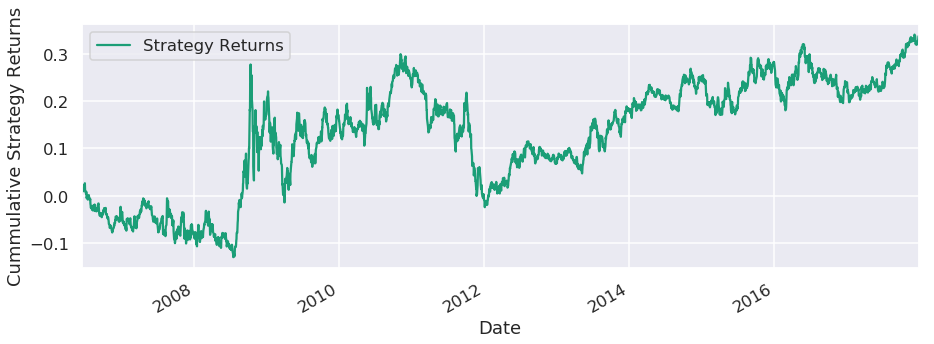

In [13]:
# Plot ผลตอบแทนของกลยุทธ์
(df.strategy_return).cumsum().plot(figsize=(15,5), label = "Strategy Returns")

plt.xlabel('Date')
plt.ylabel('Cummulative Strategy Returns')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# ตัวอย่างข้อมูลใน DataFrame 
df.head()

,open,high,low,close,volume,fastk,fastd,slowk,slowd,SAR,Signal,asset_return,strategy_return
datetime,,,,,,,,,,,,,
2006-06-12,0.7485,0.7501,0.7442,0.7449,0,49.192364,74.462217,74.462217,77.104578,0.759481,-1.0,-0.004144,0.004144
2006-06-13,0.7449,0.7452,0.7366,0.7379,0,30.084034,72.323685,72.323685,77.709441,0.758259,-1.0,-0.009397,0.009397
2006-06-14,0.7379,0.7411,0.7344,0.7380,0,25.627240,69.962629,69.962629,78.138709,0.756526,-1.0,0.000136,-0.000136
2006-06-15,0.7379,0.7430,0.7363,0.7422,0,33.154122,67.776274,67.776274,78.389410,0.754313,-1.0,0.005691,-0.005691
2006-06-16,0.7420,0.7450,0.7373,0.7382,0,25.985663,65.436634,65.436634,78.464067,0.752322,-1.0,-0.005389,0.005389


# Analyze the Performance.

หลังจากที่เราได้เห็นผลตอบแทนของกลยุทธ์แล้ว เราจะทำการวิเคราะห์ประสิทธิภาพของกลยุทธ์ด้วย Metric 3 ตัวคือ

### 1) Sharpe Ratio
Sharpe Ratio สามารถคำนวณได้โดย การนำส่วนต่างของค่าเฉลี่ยผลตอบแทนกับ risk-free rate หารด้วย standard deviation ของผลตอบแทน จากนั้นคูณด้วย square root ของ 252 เพื่อแปลงให้เป็นรายปี

In [15]:
# สมมติให้ average annual risk-free rate ในช่วงระยะเวลา 1 ปี คือ 2%
risk_free_rate = 0.02/252

sharpe = np.sqrt(252)*(np.mean(df.strategy_return)- (risk_free_rate))/np.std(df.strategy_return)
print ("Sharpe Ratio : {:.5f}".format(sharpe))

Sharpe Ratio : 0.05959


###  2) CAGR
CAGR คือ ค่าของเปอร์เซ็นผลตอบแทนทบต้นต่อปี โดยสามารถคำนวณได้จากสูตรคือ :

<i>(Cumulative returns + 1)^(365/number of days) - 1</i>

โดย cumulative returns คือ ผลตอบแทนรวมทั้งหมดของกลยุทธ์ และ number of days จำนวนวันที่เราทำการทดสอบกลยุทธ์

In [16]:
# คำนวณค่า period_in_days หาระยะห่างระหว่างวันแรกและวันสุดท้ายที่เทรด (หน่วยเป็นวัน)
period_in_days = (df.index[-1] - df.index[0]).days

# คำนวณค่า CAGR
CAGR = ((df.strategy_return.cumsum()[-1]+1)**(365.0/period_in_days) - 1)*100

print ("CAGR : {:.2f} % ".format(CAGR))

CAGR : 2.55 % 


### 3) Maximum Drawdown

Maximum Drawdown เป็นการวัดความสูญเสียสูงสุดที่เกิดขึ้นในการเทรดด้วยกลยุทธ์นี้ โดยจะต้องทำการหาจุดที่สูงที่สุดของ Portfolio กับจุดที่ต่ำที่สุดของ Portfolio เมื่อได้จุดสองสุดแล้วทำการคำนวณหาอัตราการเปลี่ยนแปลงก็จะได้ % Maximum Drawdown

Maximum Drawdown : -32.35 %


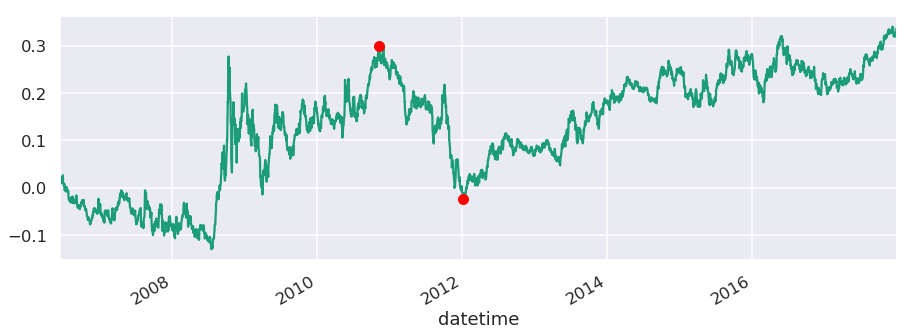

In [17]:
# ผลตอบแทนสะสมของกลยุทธ์
cum_ret = df.strategy_return.cumsum()

# หาจุดต่ำสุดของ Portfolio
trough = (np.maximum.accumulate(cum_ret) - cum_ret).idxmax() 

# หาจุดสูงสุดของ Portfolio
peak = cum_ret[:trough].idxmax()

# คำนวณ Maximum Drawdown จากสุดสูงสุดและต่ำสุด
drawdown = (cum_ret[trough] - cum_ret[peak]) * 100
print ("Maximum Drawdown : {:.2f} %".format(drawdown))

# Plot กราฟของผลตอบแทน และทำการมาร์คจุดสูงสุดและต่ำสุดของ Portfolio
cum_ret.plot(figsize=(15,5))
plt.plot([trough, peak], [cum_ret[trough], cum_ret[peak]], 'o', color='red', markersize=10)
plt.grid(True)
plt.show()

#### ทดลองแสดงผล Performance Metric ด้วย Library Tabulate

In [18]:
print (tabulate([['Sharpe ratio', sharpe], 
                ['CAGR (%)', CAGR], 
                ["Maximum Drawdown (%)", drawdown]], headers=['Performance Metrics', 'Values']))

Performance Metrics        Values
---------------------  ----------
Sharpe ratio             0.059585
CAGR (%)                 2.54845
Maximum Drawdown (%)   -32.3532


# การคำนวณ Strategy performance โดยคิดรวมค่า transaction cost และ slippage

ต่อมาเราจะคำนวณผลตอบแทนของกลยุธ์โดยรวม transaction cost และ slippage เข้าไปด้วย โดยวิธีการคือ

เราจะเสีย transaction cost และ slippage ก็ต่อเมื่อเรามีการซื้อหรือขายเท่านั้น ส่วนในช่วงที่เราถือ Position เราจะไม่เสีย transaction cost และ slippage ดังนั้นเราจะนับช่วงที่การซื้อหรือขายแล้วทำการคูณกับค่า transaction cost และ slippage ที่ตั้งค่าไว้ จากนั้นนำค่าที่ได้ซึ่งก็คือค่าใช้จ่ายที่เกิดขึ้นจาก transaction cost และ slippage ไปลบออกจากผลตอบแทนของกลยุทธ์

ในกรณีนี้เราจะสมมติให้ transaction cost และ slippage เป็น 0.001% และ 0.001% ต่อหนึ่งหน่วยการซื้อขาย 

### Strategy Return with Transaction Cost and Slippage

In [19]:
# ทำการคำนวณผลตอบแทนของกลยุทธ์ใหม่

strategy_ret_minus_cost = df.strategy_return - ((0.0001 + 0.0001) * np.abs(df.Signal - df.Signal.shift(1)))
strategy_ret_minus_cost = strategy_ret_minus_cost.dropna()

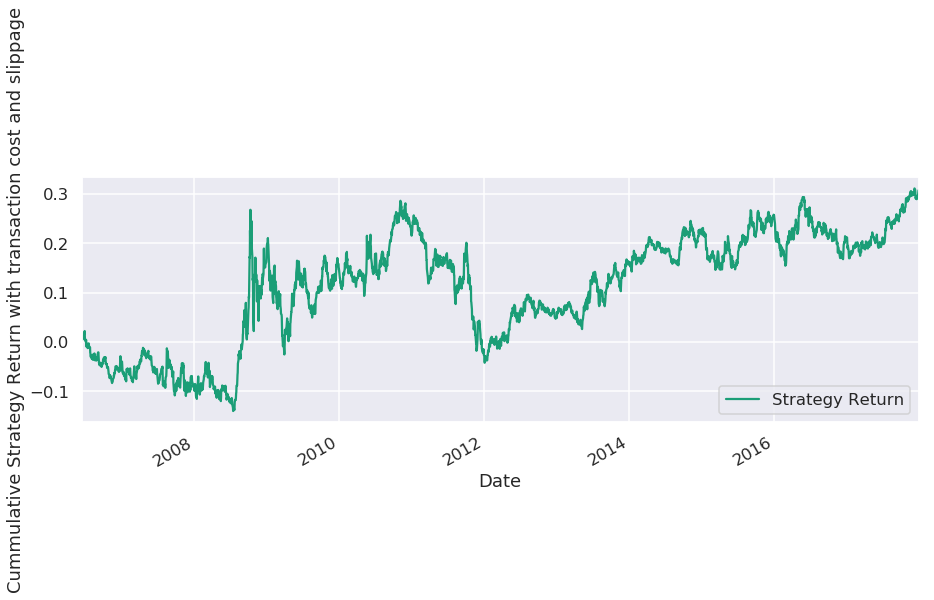

In [20]:
# Plot ผลตอบแทนของกลยุทธ์
strategy_ret_minus_cost.cumsum().plot(figsize=(15, 5), label = 'Strategy Return')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Cummulative Strategy Return with transaction cost and slippage')
plt.legend()
plt.show()

### 1) Sharp ratio

In [21]:
# ทำการคำนวณค่า Sharpe Raito จากผลตอบแทนของกลยุทธ์ที่หักค่า transaction cost และ slippage แล้ว

sharpe_with_transaction = np.sqrt(252)*(np.mean(strategy_ret_minus_cost)- (risk_free_rate))/np.std(strategy_ret_minus_cost)

print ("Sharpe Ratio : {:.5f}".format(sharpe_with_transaction))

Sharpe Ratio : 0.04155


### 2) CAGR

In [22]:
# ทำการคำนวณค่า CAGR จากผลตอบแทนของกลยุทธ์ที่หักค่า transaction cost และ slippage แล้ว

CAGR_with_transaction = ((strategy_ret_minus_cost.cumsum()[-1]+1)**(365.0/period_in_days) - 1)*100

print ("CAGR : {:.2f} % ".format(CAGR))

CAGR : 2.55 % 


### 3) Maximum Drawdown

Maximum Drawdown : -32.35 %


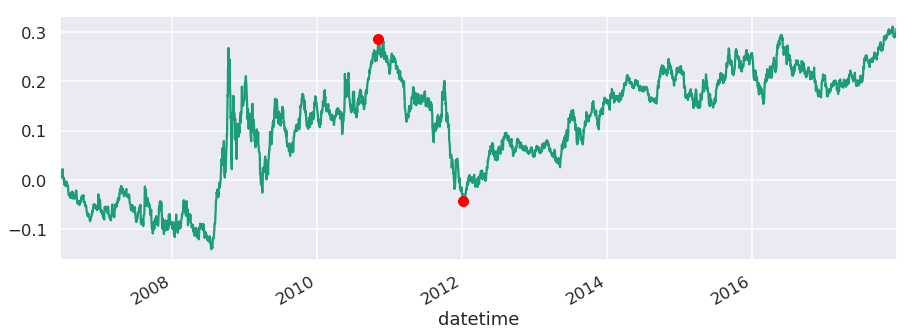

In [23]:
cum_ret_minus_cost = strategy_ret_minus_cost.cumsum()
cum_ret_minus_cost = cum_ret_minus_cost.dropna()

trough = (np.maximum.accumulate(cum_ret_minus_cost) - cum_ret_minus_cost).idxmax()
peak = cum_ret_minus_cost[:trough].idxmax() 
drawdown_with_transaction = (cum_ret_minus_cost[trough] - cum_ret_minus_cost[peak])*100
print ("Maximum Drawdown : {:.2f} %".format(drawdown))

cum_ret_minus_cost.plot(figsize=(15,5))
plt.plot([trough, peak], [cum_ret_minus_cost[trough], cum_ret_minus_cost[peak]], 'o', color='red', markersize=10)
plt.grid(True)
plt.show()

### แสดงผล Performance เทียบกันระหว่างผลตอบแทนของกลยุทธ์ก่อนและหลังคิดค่า Transaction Cost และ Slippage

In [24]:
print (tabulate([['Sharpe ratio', sharpe, sharpe_with_transaction], 
                ['CAGR (%)', CAGR, CAGR_with_transaction],
                ["Maximum Drawdown (%)", drawdown, drawdown_with_transaction ]], headers=['Performance Metrics', 'Pure Strategy Return', 'Transaction Cost and Slippage']))

Performance Metrics      Pure Strategy Return    Transaction Cost and Slippage
---------------------  ----------------------  -------------------------------
Sharpe ratio                         0.059585                        0.0415501
CAGR (%)                             2.54845                         2.34637
Maximum Drawdown (%)               -32.3532                        -32.7932


## เทียบผลตอบแทนระหว่างผลตอบแทนของกลยุทธ์และผลตอบแทนของสินทรัพย์

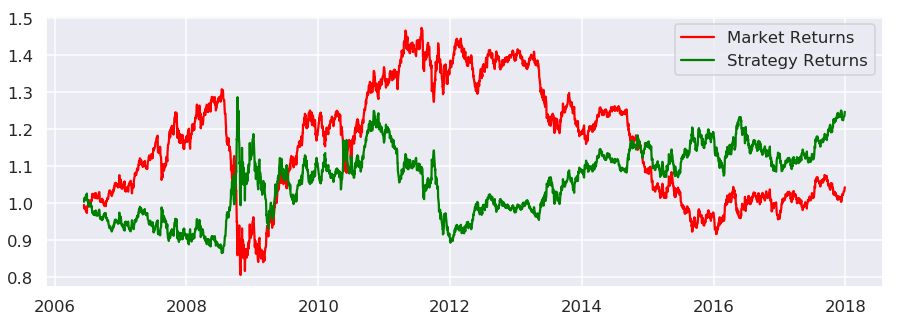

In [25]:
# Df.set_index("Time", inplace=True)
# Plot the stretegy returns
plt.figure(figsize=(15, 5))
plt.plot(((df['asset_return']+1).cumprod()),color='r',label='Market Returns')
plt.plot(((df['strategy_return']+1).cumprod()),color='g',label='Strategy Returns')
plt.legend()
plt.show()